<a href="https://colab.research.google.com/github/ArgyChris/ExerciseAugmenta/blob/main/exposure_data_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmenta exercise,
## Author: Argyrios Christodoulidis, 29/06/2023
## Cloud computing environment for model building, evaluation, testing, and extraction:

The following notebook includes the following sections:

1.   Computing environment set up
2.   External data loading, preprocessing, and preparation
3.   Model environment set up
4.   Model experimentation: training of different models, hyperparameter tuning
5.   Model evaluation
6.   Model and Scaler saving and extraction


###Brief description:
The general flow of the work includes setting up the packages, then performing some checks for the computing environment, following that, data loading and normalization takes place. The main computations follow with model building, hyperparameter tuning, and the core model training that requires allocated GPU resources to run. Finally, the choosen trained model is tested, and then together with the Scaler that was used for normalization are both extracted to a local folder.       

##Section 1: Computing environment set up

The models are build on keras, so the relevant imports of tensorflow and keras modules takes place here. The imports are done using the built-in magic command %.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##Section 2: External data loading, preprocessing, and preparation

The google colab location is mounted and the exposure_dataset.csv is loaded using pandas.

A global scaler that performs z-normalization (0 mean, 1 standard deviation) is used to normalize the data along the columns. Later on we will extract the scaler to use it during inference.

The preparation involves the data spliting to training, validation, and testing sets. We choose 60% of the total number of sequences for training and the rest for validation and testing sets.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Data loading
file_path = '/content/drive/MyDrive/Colab Notebooks/exposure_dataset.csv'

In [5]:
#Data reading
import pandas as pd
df = pd.read_csv(file_path)

In [6]:
print(df)

       pixel_value  sensor_value  exposure
0         7.701034   2175.587020  0.022000
1         5.815941   2181.119258  0.023100
2         7.024709   2275.419955  0.024255
3         9.315637   2236.333785  0.025468
4         5.564641   2177.587197  0.026741
...            ...           ...       ...
24995   111.383149  20047.104237  0.578237
24996   112.070445  19955.801369  0.607149
24997   110.426177  20027.076572  0.637506
24998   118.124573  20051.621709  0.669381
24999   114.848397  20048.122759  0.702850

[25000 rows x 3 columns]


In [7]:
#Data normalization: Apply global scaler, z-normalization for 0 mean and 1 std, keep the scaler for inverse and inference
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
df_normalized = scaler.transform(df)

#Setting the sliding window size of the data/model, this can act as hyperparameter
n_steps = 167
num_sequences = len(df_normalized) - n_steps  # Number of sequences to create
series_reshaped = []

for i in range(num_sequences):
    sequence = df_normalized[i:i + n_steps].copy()
    series_reshaped.append(sequence)

series_reshaped = np.array(series_reshaped)


### Section 2b: Testing if we can use the Scaler for reconstructing back to the original data

In [10]:
series_reshaped.shape

(24833, 167, 3)

In [11]:
series_reshaped[0][0]

array([-1.18097746, -1.73654999, -0.50282449])

In [12]:
sequence_original = scaler.inverse_transform(series_reshaped[0][0].reshape(1, -1))
print(sequence_original)

[[7.70103375e+00 2.17558702e+03 2.20000000e-02]]


In [13]:
p = df.iloc[0][:]
print(p)

pixel_value        7.701034
sensor_value    2175.587020
exposure           0.022000
Name: 0, dtype: float64


In [14]:
series_reshaped.shape

(24833, 167, 3)

In [15]:
series_reshaped[0, :, -1]

array([-5.02824488e-01, -5.02634787e-01, -5.02435601e-01, -5.02226455e-01,
       -5.02006853e-01, -5.01776270e-01, -5.01534159e-01, -5.01279941e-01,
       -5.01013013e-01, -5.00732738e-01, -5.00438450e-01, -5.00129447e-01,
       -4.99804994e-01, -4.99464319e-01, -4.99106609e-01, -4.98731014e-01,
       -4.98336640e-01, -4.97922547e-01, -4.97487749e-01, -4.97031211e-01,
       -4.96551846e-01, -4.96048513e-01, -4.95520013e-01, -4.94965089e-01,
       -4.94382418e-01, -4.93770613e-01, -4.93128219e-01, -4.92453704e-01,
       -4.91745464e-01, -4.91001812e-01, -4.90220978e-01, -4.89401101e-01,
       -4.88540231e-01, -4.87636317e-01, -4.86687208e-01, -4.85690643e-01,
       -4.84644250e-01, -4.83545537e-01, -4.82391889e-01, -4.81180558e-01,
       -4.79908660e-01, -4.78573168e-01, -4.77170901e-01, -4.75698521e-01,
       -4.74152522e-01, -4.72529222e-01, -4.70824758e-01, -4.69035071e-01,
       -4.67155899e-01, -4.65182769e-01, -4.63110982e-01, -4.60935606e-01,
       -4.58651461e-01, -

In [16]:
series_reshaped[0, :, -1].shape

(167,)

## Section 2c: Data split to training, validation, and testing

In [18]:

# Split the data into training and remaining data
X_train, X_remain, Y_train, Y_remain = train_test_split(
    series_reshaped[:, :, :2],  # Features (first 2 columns)
    series_reshaped[:, :, -1],  # Target (the last columns)
    test_size=0.4,           # 40% for remaining data (train + validation)
    random_state=42
)

# # Split the remaining data into validation and test sets
X_val, X_test, Y_val, Y_test = train_test_split(
    X_remain,               # Features from remaining data
    Y_remain,               # Target from remaining data
    test_size=0.5,          # 50% for validation and test (20% each)
    random_state=42
)

In [19]:
X_train.shape

(14899, 167, 2)

In [20]:
X_train[0]

array([[-1.0692425 , -0.37518874],
       [-1.07154252, -0.3702273 ],
       [-1.1037413 , -0.39348853],
       [-1.05431479, -0.35145856],
       [-1.06706416, -0.36540774],
       [-1.06177089, -0.38683299],
       [-1.03619775, -0.36267405],
       [-1.04046006, -0.37472504],
       [-1.03743932, -0.36804305],
       [-0.98698415, -0.37026705],
       [-1.03043035, -0.34748391],
       [-1.03422605, -0.39020674],
       [-1.04378108, -0.37168461],
       [-0.99448211, -0.37958139],
       [-1.03545368, -0.36549297],
       [-0.98155257, -0.36365063],
       [-0.99373943, -0.37037018],
       [-0.98337   , -0.37655631],
       [-0.92432491, -0.3595847 ],
       [-0.97532162, -0.35696694],
       [-0.9633396 , -0.36099346],
       [-0.94460194, -0.3631183 ],
       [-0.94478953, -0.37376097],
       [-0.94290559, -0.37816721],
       [-0.89442658, -0.37240502],
       [-0.9276949 , -0.35764662],
       [-0.90368014, -0.36447507],
       [-0.89869835, -0.37547811],
       [-0.88328926,

In [21]:
Y_train[0]

array([-0.50153416, -0.50127994, -0.50101301, -0.50073274, -0.50043845,
       -0.50012945, -0.49980499, -0.49946432, -0.49910661, -0.49873101,
       -0.49833664, -0.49792255, -0.49748775, -0.49703121, -0.49655185,
       -0.49604851, -0.49552001, -0.49496509, -0.49438242, -0.49377061,
       -0.49312822, -0.4924537 , -0.49174546, -0.49100181, -0.49022098,
       -0.4894011 , -0.48854023, -0.48763632, -0.48668721, -0.48569064,
       -0.48464425, -0.48354554, -0.48239189, -0.48118056, -0.47990866,
       -0.47857317, -0.4771709 , -0.47569852, -0.47415252, -0.47252922,
       -0.47082476, -0.46903507, -0.4671559 , -0.46518277, -0.46311098,
       -0.46093561, -0.45865146, -0.45625311, -0.45373484, -0.45109066,
       -0.44831426, -0.44539905, -0.44233808, -0.43912406, -0.43574933,
       -0.43220588, -0.42848524, -0.42457858, -0.42047658, -0.41616949,
       -0.41164704, -0.40689846, -0.40191246, -0.39667716, -0.39118009,
       -0.38540817, -0.37934766, -0.37298411, -0.36630239, -0.35

In [22]:
Y_val.shape

(4967, 167)

In [23]:
X_test.shape

(4967, 167, 2)

## Section 3: Model environment set up

In [17]:
from sklearn.model_selection import train_test_split

In [24]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

### Section 3b: Visualization plot function

In [26]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

## Section 4: Main model training section. Setting the models, the hyperparameters, the regularizers, the tuning.

First we set the early stopping, a regularization technique, to monitor the validation loss, and stop the training if there is no improvement.

We performed experiments using models that have been proposed to work on sequences, the Deep RNNs and LSTMs.

In keras, the model building is abstracted at a high degree so we only have to set up the number of units, the fully connected or dense layer and its output, 1 single value that represents the exposure time in our case, the number of sequential layers, the type of loss function, the optimizer, a possible dropout for extra regularization, and finally the number of training epochs.

As a first exploratory step we tried different settings. For the best architecture, or the one that looked more promising, we considered the dropout and the number of units as hyperparameters, and we used Optuna toolkit to find the best values for the hyperparamters. Having the values we expanded our training to more epochs.

In [25]:
es = EarlyStopping(monitor = 'val_loss')

In [27]:
#Deep Recurrent Neural Network
np.random.seed(42)
tf.random.set_seed(42)

DRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 2]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

DRNN.compile(loss="mape", optimizer="adam")
history_RNN = DRNN.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_val, Y_val))

Epoch 1/20
466/466 [==============================] - 162s 333ms/step - loss: 26.0172 - val_loss: 14.9333
Epoch 2/20
466/466 [==============================] - 152s 327ms/step - loss: 12.9604 - val_loss: 11.4247
Epoch 3/20
466/466 [==============================] - 156s 335ms/step - loss: 10.1469 - val_loss: 9.5753
Epoch 4/20
466/466 [==============================] - 153s 328ms/step - loss: 9.1747 - val_loss: 7.8983
Epoch 5/20
466/466 [==============================] - 156s 336ms/step - loss: 7.9599 - val_loss: 8.3231
Epoch 6/20
466/466 [==============================] - 155s 333ms/step - loss: 7.4239 - val_loss: 6.8605
Epoch 7/20
466/466 [==============================] - 153s 327ms/step - loss: 6.7452 - val_loss: 5.9295
Epoch 8/20
466/466 [==============================] - 156s 334ms/step - loss: 6.3825 - val_loss: 5.9327
Epoch 9/20
466/466 [==============================] - 155s 333ms/step - loss: 5.9241 - val_loss: 6.0644
Epoch 10/20
466/466 [==============================] - 154s

In [ ]:
# Deep LSTM model
np.random.seed(42)
tf.random.set_seed(42)

DeepLSTM = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(167,2)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

DeepLSTM.compile(loss="mape", optimizer="adam")
history_DeepLSTM = DeepLSTM.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_val, Y_val), callbacks = [es] )

Epoch 1/20
466/466 [==============================] - 22s 30ms/step - loss: 15.8311 - val_loss: 6.8480
Epoch 2/20
466/466 [==============================] - 16s 34ms/step - loss: 7.8886 - val_loss: 6.2141
Epoch 3/20
466/466 [==============================] - 12s 25ms/step - loss: 6.3631 - val_loss: 4.6678
Epoch 4/20
466/466 [==============================] - 11s 23ms/step - loss: 5.4097 - val_loss: 3.5787
Epoch 5/20
466/466 [==============================] - 9s 20ms/step - loss: 4.8565 - val_loss: 3.1898
Epoch 6/20
466/466 [==============================] - 10s 22ms/step - loss: 4.3963 - val_loss: 3.3163


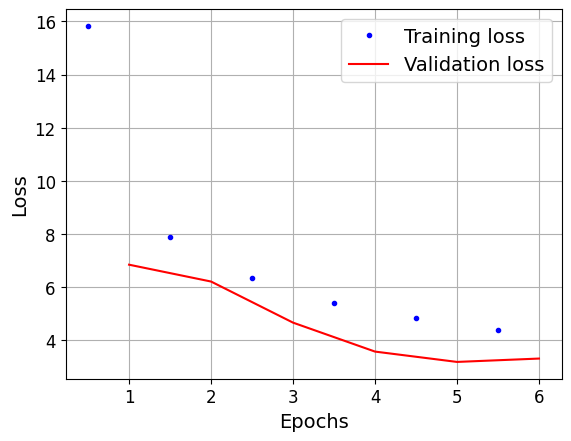

In [ ]:
plot_learning_curves(history_DeepLSTM.history["loss"], history_DeepLSTM.history["val_loss"])
plt.show()

In [ ]:
# Simple Long-Short Term Memory model
np.random.seed(42)
tf.random.set_seed(42)

number_of_LSTM_units = 20 #hyperparameter
model8 = keras.models.Sequential([
    keras.layers.LSTM(number_of_LSTM_units, return_sequences=True, input_shape=[None, 2]),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model8.compile(loss="mape", optimizer="adam")
history_LSTM_50_epochs = model8.fit(X_train, Y_train, epochs=50,
                    validation_data=(X_val, Y_val))

Epoch 1/50
466/466 [==============================] - 8s 12ms/step - loss: 19.8777 - val_loss: 10.4889
Epoch 2/50
466/466 [==============================] - 4s 9ms/step - loss: 7.5824 - val_loss: 5.6868
Epoch 3/50
466/466 [==============================] - 4s 9ms/step - loss: 5.1557 - val_loss: 4.7604
Epoch 4/50
466/466 [==============================] - 6s 13ms/step - loss: 4.5394 - val_loss: 4.1591
Epoch 5/50
466/466 [==============================] - 7s 14ms/step - loss: 4.0969 - val_loss: 3.8760
Epoch 6/50
466/466 [==============================] - 7s 15ms/step - loss: 3.8545 - val_loss: 3.8185
Epoch 7/50
466/466 [==============================] - 4s 9ms/step - loss: 3.6399 - val_loss: 3.4721
Epoch 8/50
466/466 [==============================] - 4s 9ms/step - loss: 3.4600 - val_loss: 3.7495
Epoch 9/50
466/466 [==============================] - 5s 11ms/step - loss: 3.3749 - val_loss: 3.4113
Epoch 10/50
466/466 [==============================] - 4s 9ms/step - loss: 3.1968 - val_loss:

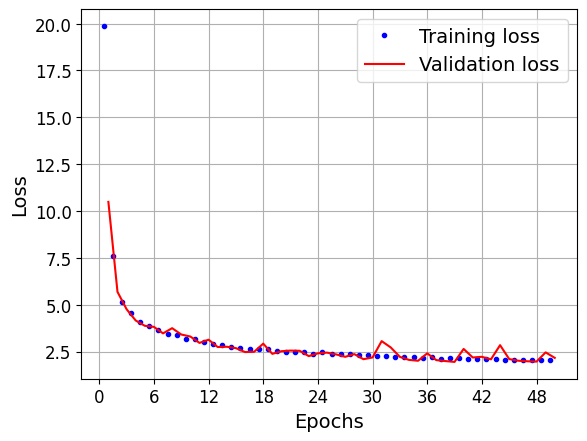

In [ ]:
plot_learning_curves(history_LSTM_50_epochs.history["loss"], history_LSTM_50_epochs.history["val_loss"])
plt.show()

## Optuna (https://optuna.org/): Is an open source hyperparameter optimization framework to automate hyperparameter search. The default algorithm is based on a Tree-structured Parzen Estimator (TPE). TPE is a Bayesian optimization algorithm that efficiently explores the search space by modeling the relationship between hyperparameters and the objective function.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.4 MB/s eta 0:00:00


In [ ]:
#Optuna trials to find the best number of units and dropout for our LSTM model
import optuna

np.random.seed(42)
tf.random.set_seed(42)

def objective(trial):
    # Define the search space for the number of units and the dropout
    n_units = trial.suggest_int('n_units', 10, 100)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.4)

    # Build the LSTM model with the specified number of units and dropout rate as hyperparameter
    model_optuna = keras.models.Sequential([
        keras.layers.LSTM(n_units, return_sequences=True, input_shape=[None, 2]),
        keras.layers.Dropout(dropout_rate),
        keras.layers.TimeDistributed(keras.layers.Dense(1))
    ])

    # Compile the model
    model_optuna.compile(loss='mape', optimizer='adam')

    # Train the model and return the metric to optimize (e.g., validation loss)
    history_LSTM_optuna = model_optuna.fit(X_train, Y_train, epochs=100,
                          validation_data=(X_val, Y_val), callbacks=[es])
    val_loss = history_LSTM_optuna.history['val_loss'][-1]
    return val_loss

# Configure Optuna study: Tree-structured Parzen Estimator (TPE) algorithm
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters:", best_params)
print('Best Objective Value:', best_value)

[I 2023-06-28 19:32:21,635] A new study created in memory with name: no-name-404ef807-de96-41f4-b4a3-55b330dd1df1
<ipython-input-33-f239d9d46070>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.4)


Epoch 1/100
466/466 [==============================] - 8s 10ms/step - loss: 24.3677 - val_loss: 8.6809
Epoch 2/100
466/466 [==============================] - 5s 12ms/step - loss: 9.6445 - val_loss: 5.3871
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 7.8256 - val_loss: 4.8526
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.1090 - val_loss: 4.3231
Epoch 5/100
466/466 [==============================] - 6s 12ms/step - loss: 6.6708 - val_loss: 3.7418
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 6.3834 - val_loss: 3.8278


[I 2023-06-28 19:32:54,204] Trial 0 finished with value: 3.8278005123138428 and parameters: {'n_units': 32, 'dropout_rate': 0.058309081699874414}. Best is trial 0 with value: 3.8278005123138428.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 16.3378 - val_loss: 6.9528
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0232 - val_loss: 4.9346
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 5.6940 - val_loss: 4.0839
Epoch 4/100
466/466 [==============================] - 5s 12ms/step - loss: 5.0322 - val_loss: 3.9944
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 4.5618 - val_loss: 4.1076


[I 2023-06-28 19:33:21,307] Trial 1 finished with value: 4.107555389404297 and parameters: {'n_units': 65, 'dropout_rate': 0.015369676985375414}. Best is trial 0 with value: 3.8278005123138428.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 32.4070 - val_loss: 12.6259
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 15.1020 - val_loss: 8.5613
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 11.6605 - val_loss: 6.2543
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 10.5984 - val_loss: 5.4975
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 10.0655 - val_loss: 5.5453


[I 2023-06-28 19:34:03,297] Trial 2 finished with value: 5.545263767242432 and parameters: {'n_units': 17, 'dropout_rate': 0.09631667718210486}. Best is trial 0 with value: 3.8278005123138428.


Epoch 1/100
466/466 [==============================] - 9s 14ms/step - loss: 17.5109 - val_loss: 6.0258
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 8.9509 - val_loss: 4.7606
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.0489 - val_loss: 4.3437
Epoch 4/100
466/466 [==============================] - 5s 12ms/step - loss: 7.5511 - val_loss: 3.6840
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 7.2583 - val_loss: 3.5255
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0762 - val_loss: 3.6161


[I 2023-06-28 19:34:35,672] Trial 3 finished with value: 3.616140365600586 and parameters: {'n_units': 98, 'dropout_rate': 0.24016050069340925}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 9s 10ms/step - loss: 23.7165 - val_loss: 7.8276
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 12.8139 - val_loss: 5.9533
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 11.9044 - val_loss: 4.7816
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 11.4551 - val_loss: 4.8400


[I 2023-06-28 19:34:58,701] Trial 4 finished with value: 4.8400068283081055 and parameters: {'n_units': 52, 'dropout_rate': 0.3663569420659671}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 21.6442 - val_loss: 7.3038
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 11.4557 - val_loss: 5.7289
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 10.5420 - val_loss: 5.1517
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 9.9707 - val_loss: 4.3857
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 9.5996 - val_loss: 5.3352


[I 2023-06-28 19:35:25,837] Trial 5 finished with value: 5.335230350494385 and parameters: {'n_units': 60, 'dropout_rate': 0.2979196744390014}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 9s 14ms/step - loss: 16.2505 - val_loss: 5.4933
Epoch 2/100
466/466 [==============================] - 9s 20ms/step - loss: 7.4252 - val_loss: 4.4841
Epoch 3/100
466/466 [==============================] - 8s 17ms/step - loss: 6.3126 - val_loss: 3.7246
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 5.8542 - val_loss: 3.8758


[I 2023-06-28 19:36:12,949] Trial 6 finished with value: 3.8757550716400146 and parameters: {'n_units': 90, 'dropout_rate': 0.09539022390773583}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 22.5084 - val_loss: 7.1167
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 12.3674 - val_loss: 6.0712
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 11.4777 - val_loss: 4.7285
Epoch 4/100
466/466 [==============================] - 4s 10ms/step - loss: 11.0768 - val_loss: 4.4946
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 10.7904 - val_loss: 4.7152


[I 2023-06-28 19:36:40,444] Trial 7 finished with value: 4.715219974517822 and parameters: {'n_units': 62, 'dropout_rate': 0.3777318639781096}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 21.0787 - val_loss: 7.4752
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.9908 - val_loss: 6.2222
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 9.0132 - val_loss: 5.4546
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.5252 - val_loss: 4.5844
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 8.1932 - val_loss: 3.7559
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.9758 - val_loss: 4.5148


[I 2023-06-28 19:37:11,662] Trial 8 finished with value: 4.514807224273682 and parameters: {'n_units': 51, 'dropout_rate': 0.180988156647594}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 8s 10ms/step - loss: 21.3701 - val_loss: 6.4499
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 11.3683 - val_loss: 5.2068
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 10.6125 - val_loss: 5.1519
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 10.1106 - val_loss: 4.3091
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 9.7614 - val_loss: 5.0264


[I 2023-06-28 19:37:50,643] Trial 9 finished with value: 5.026352405548096 and parameters: {'n_units': 67, 'dropout_rate': 0.33267292790629976}. Best is trial 3 with value: 3.616140365600586.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 17.8600 - val_loss: 5.8244
Epoch 2/100
466/466 [==============================] - 5s 12ms/step - loss: 9.0906 - val_loss: 5.2466
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.0689 - val_loss: 4.9593
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.7107 - val_loss: 3.9938
Epoch 5/100
466/466 [==============================] - 5s 12ms/step - loss: 7.2860 - val_loss: 3.2893
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0779 - val_loss: 3.4822


[I 2023-06-28 19:38:39,753] Trial 10 finished with value: 3.4822003841400146 and parameters: {'n_units': 100, 'dropout_rate': 0.24921456900630065}. Best is trial 10 with value: 3.4822003841400146.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.8421 - val_loss: 7.7037
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.2634 - val_loss: 5.3243
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3076 - val_loss: 4.3771
Epoch 4/100
466/466 [==============================] - 5s 12ms/step - loss: 7.8207 - val_loss: 4.3346
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.4423 - val_loss: 3.3906
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.2170 - val_loss: 3.3271
Epoch 7/100
466/466 [==============================] - 6s 12ms/step - loss: 7.0433 - val_loss: 3.3521


[I 2023-06-28 19:39:16,753] Trial 11 finished with value: 3.3521134853363037 and parameters: {'n_units': 98, 'dropout_rate': 0.25946671217897116}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 10s 14ms/step - loss: 19.6266 - val_loss: 7.0491
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.6911 - val_loss: 5.0684
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.7738 - val_loss: 5.3994


[I 2023-06-28 19:39:40,990] Trial 12 finished with value: 5.399361610412598 and parameters: {'n_units': 83, 'dropout_rate': 0.2567087357868055}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 17.9662 - val_loss: 6.4598
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 8.8493 - val_loss: 5.0487
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 7.9640 - val_loss: 5.5906


[I 2023-06-28 19:39:59,417] Trial 13 finished with value: 5.590575695037842 and parameters: {'n_units': 82, 'dropout_rate': 0.18930354695020593}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.4272 - val_loss: 5.9963
Epoch 2/100
466/466 [==============================] - 5s 12ms/step - loss: 9.1747 - val_loss: 4.5382
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.2369 - val_loss: 4.8915


[I 2023-06-28 19:40:17,822] Trial 14 finished with value: 4.891514778137207 and parameters: {'n_units': 99, 'dropout_rate': 0.26771925046313133}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.3461 - val_loss: 5.8970
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.1509 - val_loss: 5.0713
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3180 - val_loss: 4.3943
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.8107 - val_loss: 4.5098


[I 2023-06-28 19:40:40,314] Trial 15 finished with value: 4.509838581085205 and parameters: {'n_units': 78, 'dropout_rate': 0.21435304024093615}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.8513 - val_loss: 6.6700
Epoch 2/100
466/466 [==============================] - 6s 13ms/step - loss: 9.6144 - val_loss: 5.3453
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 8.6652 - val_loss: 4.1286
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.2766 - val_loss: 4.2673


[I 2023-06-28 19:41:04,797] Trial 16 finished with value: 4.267319679260254 and parameters: {'n_units': 100, 'dropout_rate': 0.3050834490404263}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 24.5537 - val_loss: 8.0992
Epoch 2/100
466/466 [==============================] - 6s 13ms/step - loss: 11.3560 - val_loss: 6.2300
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.9246 - val_loss: 5.2184
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 9.3505 - val_loss: 5.2646


[I 2023-06-28 19:41:46,662] Trial 17 finished with value: 5.264561653137207 and parameters: {'n_units': 38, 'dropout_rate': 0.1595040897902232}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 9s 14ms/step - loss: 20.7606 - val_loss: 6.2427
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.7607 - val_loss: 5.3090
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.8488 - val_loss: 5.1673
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.2590 - val_loss: 4.0816
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.8705 - val_loss: 4.1550


[I 2023-06-28 19:42:34,884] Trial 18 finished with value: 4.1549973487854 and parameters: {'n_units': 73, 'dropout_rate': 0.21678795601857243}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 11s 16ms/step - loss: 19.4528 - val_loss: 6.4431
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 10.1102 - val_loss: 5.6327
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 9.2501 - val_loss: 5.0558
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.7357 - val_loss: 5.2290


[I 2023-06-28 19:43:15,962] Trial 19 finished with value: 5.228975296020508 and parameters: {'n_units': 90, 'dropout_rate': 0.3008554220507559}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 18.4512 - val_loss: 6.2166
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 8.4405 - val_loss: 4.8788
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 7.4133 - val_loss: 4.7035
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 6.8709 - val_loss: 3.7339
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 6.4800 - val_loss: 3.4339
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 6.2186 - val_loss: 3.5020


[I 2023-06-28 19:44:06,590] Trial 20 finished with value: 3.501967668533325 and parameters: {'n_units': 89, 'dropout_rate': 0.15903650861851387}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 7s 10ms/step - loss: 16.6893 - val_loss: 6.3298
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 8.1526 - val_loss: 5.1088
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 7.2758 - val_loss: 4.2850
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 6.8352 - val_loss: 3.7896
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 6.4585 - val_loss: 3.8741


[I 2023-06-28 19:44:33,202] Trial 21 finished with value: 3.8740522861480713 and parameters: {'n_units': 89, 'dropout_rate': 0.15049118398351663}. Best is trial 11 with value: 3.3521134853363037.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.2577 - val_loss: 6.5966
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.1174 - val_loss: 4.9248
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 8.1990 - val_loss: 4.2275
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7928 - val_loss: 3.9176
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.4083 - val_loss: 3.6964
Epoch 6/100
466/466 [==============================] - 5s 12ms/step - loss: 7.1488 - val_loss: 3.4200
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0429 - val_loss: 3.1462
Epoch 8/100
466/466 [==============================] - 4s 10ms/step - loss: 6.8708 - val_loss: 3.1920


[I 2023-06-28 19:45:14,610] Trial 22 finished with value: 3.1919944286346436 and parameters: {'n_units': 91, 'dropout_rate': 0.241076671120839}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 8s 10ms/step - loss: 18.3246 - val_loss: 5.8039
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 8.9957 - val_loss: 5.2543
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 8.1163 - val_loss: 4.5092
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.6715 - val_loss: 4.7109


[I 2023-06-28 19:45:37,037] Trial 23 finished with value: 4.710912227630615 and parameters: {'n_units': 95, 'dropout_rate': 0.24946463477806732}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 21.4510 - val_loss: 7.7078
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 10.7240 - val_loss: 5.9759
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.6748 - val_loss: 4.8930
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 9.1179 - val_loss: 4.6497
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 8.7826 - val_loss: 4.0816
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 8.5910 - val_loss: 3.8871
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 8.3942 - val_loss: 3.5764
Epoch 8/100
466/466 [==============================] - 5s 10ms/step - loss: 8.2467 - val_loss: 3.4883
Epoch 9/100
466/466 [==============================] - 6s 12ms/step - loss: 8.0938 - val_loss: 3.8714


[I 2023-06-28 19:46:23,762] Trial 24 finished with value: 3.8713772296905518 and parameters: {'n_units': 74, 'dropout_rate': 0.2794366988086325}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 9s 10ms/step - loss: 19.0000 - val_loss: 5.9205
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.2011 - val_loss: 4.8129
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 8.2456 - val_loss: 4.5878
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7591 - val_loss: 4.2535
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.4017 - val_loss: 3.9450
Epoch 6/100
466/466 [==============================] - 5s 12ms/step - loss: 7.2064 - val_loss: 3.2732
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0309 - val_loss: 3.4802


[I 2023-06-28 19:47:01,512] Trial 25 finished with value: 3.4802496433258057 and parameters: {'n_units': 84, 'dropout_rate': 0.21833421678443032}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.5126 - val_loss: 6.2684
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 9.5954 - val_loss: 5.3355
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.6321 - val_loss: 4.5931
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.1696 - val_loss: 4.0883
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7681 - val_loss: 4.4734


[I 2023-06-28 19:47:28,719] Trial 26 finished with value: 4.47335147857666 and parameters: {'n_units': 81, 'dropout_rate': 0.2346970330751359}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.4251 - val_loss: 6.8544
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.3907 - val_loss: 5.3516
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.5294 - val_loss: 4.7822
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.9544 - val_loss: 3.7457
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.6695 - val_loss: 3.8195


[I 2023-06-28 19:47:55,696] Trial 27 finished with value: 3.8195276260375977 and parameters: {'n_units': 72, 'dropout_rate': 0.20979210335155044}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 27.9865 - val_loss: 7.3506
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 13.3606 - val_loss: 6.0735
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 12.3282 - val_loss: 5.3710
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 11.7842 - val_loss: 4.9760
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 11.4729 - val_loss: 4.9662
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 11.2480 - val_loss: 4.8369
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 11.0691 - val_loss: 4.6706
Epoch 8/100
466/466 [==============================] - 5s 11ms/step - loss: 10.9384 - val_loss: 3.8246
Epoch 9/100
466/466 [==============================] - 4s 9ms/step - loss: 10.7969 - val_loss: 4.2353


[I 2023-06-28 19:48:40,284] Trial 28 finished with value: 4.235311985015869 and parameters: {'n_units': 44, 'dropout_rate': 0.3298603374405167}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 37.5124 - val_loss: 13.1846
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 18.1374 - val_loss: 8.2878
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 15.8188 - val_loss: 7.2667
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 14.9658 - val_loss: 6.4023
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 14.6185 - val_loss: 6.4903


[I 2023-06-28 19:49:06,528] Trial 29 finished with value: 6.490286827087402 and parameters: {'n_units': 19, 'dropout_rate': 0.2729024029502266}. Best is trial 22 with value: 3.1919944286346436.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 18.7458 - val_loss: 5.7486
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.1260 - val_loss: 4.9064
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.2614 - val_loss: 4.8350
Epoch 4/100
466/466 [==============================] - 5s 12ms/step - loss: 7.7550 - val_loss: 3.9044
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 7.3371 - val_loss: 3.6409
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0787 - val_loss: 3.3351
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 6.9486 - val_loss: 3.2762
Epoch 8/100
466/466 [==============================] - 6s 12ms/step - loss: 6.7550 - val_loss: 3.1396
Epoch 9/100
466/466 [==============================] - 4s 9ms/step - loss: 6.6039 - val_loss: 2.8280
Epoch 10/100
466/466 [==============================] - 6s 12ms/step - loss: 6.5245 

[I 2023-06-28 19:50:04,280] Trial 30 finished with value: 2.8309476375579834 and parameters: {'n_units': 85, 'dropout_rate': 0.22534758805513347}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.9593 - val_loss: 6.7916
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 9.0687 - val_loss: 4.8062
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.1482 - val_loss: 4.4984
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 7.7008 - val_loss: 4.0859
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.3344 - val_loss: 3.8419
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.1103 - val_loss: 4.6232


[I 2023-06-28 19:50:35,727] Trial 31 finished with value: 4.623234272003174 and parameters: {'n_units': 86, 'dropout_rate': 0.22642890773997454}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.4960 - val_loss: 5.7792
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 8.4617 - val_loss: 5.8427


[I 2023-06-28 19:50:48,724] Trial 32 finished with value: 5.842678070068359 and parameters: {'n_units': 93, 'dropout_rate': 0.18547061168675222}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 19.1972 - val_loss: 7.0235
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.2883 - val_loss: 5.2450
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3782 - val_loss: 4.3624
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.8845 - val_loss: 3.8538
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.5262 - val_loss: 3.5450
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.2698 - val_loss: 3.4682
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 7.1263 - val_loss: 3.0398
Epoch 8/100
466/466 [==============================] - 5s 10ms/step - loss: 6.9952 - val_loss: 3.0688


[I 2023-06-28 19:51:39,676] Trial 33 finished with value: 3.068833351135254 and parameters: {'n_units': 77, 'dropout_rate': 0.22581219439730196}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 20.0165 - val_loss: 6.1679
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.7546 - val_loss: 5.7486
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.9412 - val_loss: 4.7233
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.3847 - val_loss: 4.0839
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 8.1168 - val_loss: 3.9326
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.9001 - val_loss: 4.1774


[I 2023-06-28 19:52:11,264] Trial 34 finished with value: 4.177361488342285 and parameters: {'n_units': 78, 'dropout_rate': 0.2516906854106154}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 13ms/step - loss: 20.2975 - val_loss: 7.2086
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 10.2033 - val_loss: 5.5718
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.1767 - val_loss: 4.6603
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.6821 - val_loss: 3.9739
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 8.2531 - val_loss: 3.8811
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 8.0353 - val_loss: 4.1367


[I 2023-06-28 19:52:54,871] Trial 35 finished with value: 4.136663913726807 and parameters: {'n_units': 68, 'dropout_rate': 0.23571291522553903}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 17.4510 - val_loss: 6.1411
Epoch 2/100
466/466 [==============================] - 6s 12ms/step - loss: 8.5415 - val_loss: 5.1307
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 7.5391 - val_loss: 4.3136
Epoch 4/100
466/466 [==============================] - 4s 10ms/step - loss: 7.0729 - val_loss: 4.0762
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 6.7434 - val_loss: 3.8837
Epoch 6/100
466/466 [==============================] - 5s 12ms/step - loss: 6.5020 - val_loss: 3.3463
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 6.3995 - val_loss: 3.1356
Epoch 8/100
466/466 [==============================] - 4s 9ms/step - loss: 6.1770 - val_loss: 3.3595


[I 2023-06-28 19:53:48,467] Trial 36 finished with value: 3.3594512939453125 and parameters: {'n_units': 96, 'dropout_rate': 0.19743910473886184}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 65.6124 - val_loss: 16.4401
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 26.4506 - val_loss: 13.2589
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 21.7310 - val_loss: 10.5961
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 19.7408 - val_loss: 8.7949
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 18.7666 - val_loss: 8.3471
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 18.2393 - val_loss: 7.4148
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 17.9415 - val_loss: 7.4683


[I 2023-06-28 19:54:24,610] Trial 37 finished with value: 7.46831750869751 and parameters: {'n_units': 11, 'dropout_rate': 0.2855484304380929}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.9768 - val_loss: 6.3886
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.6346 - val_loss: 6.1394
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 8.6259 - val_loss: 4.4726
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.0689 - val_loss: 4.0172
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.6788 - val_loss: 3.4416
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.4361 - val_loss: 3.3769
Epoch 7/100
466/466 [==============================] - 5s 10ms/step - loss: 7.2039 - val_loss: 3.0902
Epoch 8/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0884 - val_loss: 3.2201


[I 2023-06-28 19:55:12,602] Trial 38 finished with value: 3.2200536727905273 and parameters: {'n_units': 93, 'dropout_rate': 0.2586486117513251}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 10ms/step - loss: 21.1509 - val_loss: 7.4416
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 10.7970 - val_loss: 5.2914
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 9.8193 - val_loss: 4.7745
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 9.2860 - val_loss: 4.2981
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 9.0247 - val_loss: 4.4728


[I 2023-06-28 19:55:41,299] Trial 39 finished with value: 4.472795486450195 and parameters: {'n_units': 55, 'dropout_rate': 0.23825206746510574}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 22.6907 - val_loss: 7.0920
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 13.0075 - val_loss: 6.0519
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 12.1139 - val_loss: 5.5499
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 11.5839 - val_loss: 4.9881
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 11.2294 - val_loss: 4.8243
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 11.0596 - val_loss: 4.3079
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 10.8994 - val_loss: 4.0558
Epoch 8/100
466/466 [==============================] - 4s 9ms/step - loss: 10.7430 - val_loss: 4.4795


[I 2023-06-28 19:56:21,165] Trial 40 finished with value: 4.479501247406006 and parameters: {'n_units': 60, 'dropout_rate': 0.3987748114259373}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.8427 - val_loss: 6.2147
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.4650 - val_loss: 4.6654
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.4733 - val_loss: 4.8254


[I 2023-06-28 19:56:39,338] Trial 41 finished with value: 4.825417518615723 and parameters: {'n_units': 92, 'dropout_rate': 0.26449194701957873}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 18.6973 - val_loss: 5.7558
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.1901 - val_loss: 5.2521
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 8.2469 - val_loss: 4.9813
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7723 - val_loss: 3.8597
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.4710 - val_loss: 3.9101


[I 2023-06-28 19:57:07,152] Trial 42 finished with value: 3.9101083278656006 and parameters: {'n_units': 86, 'dropout_rate': 0.23281292737918668}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 10ms/step - loss: 19.9580 - val_loss: 7.4394
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.6199 - val_loss: 5.2912
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.6582 - val_loss: 4.6701
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.1553 - val_loss: 3.7544
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 7.8472 - val_loss: 4.7188


[I 2023-06-28 19:57:49,264] Trial 43 finished with value: 4.718760013580322 and parameters: {'n_units': 95, 'dropout_rate': 0.2858777162811127}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 10ms/step - loss: 20.5502 - val_loss: 6.2115
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 10.0861 - val_loss: 6.1305
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 9.1208 - val_loss: 4.9808
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.6591 - val_loss: 4.4365
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 8.3663 - val_loss: 3.9892
Epoch 6/100
466/466 [==============================] - 5s 12ms/step - loss: 8.1421 - val_loss: 4.0317


[I 2023-06-28 19:58:20,994] Trial 44 finished with value: 4.0317182540893555 and parameters: {'n_units': 77, 'dropout_rate': 0.26162509311514065}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 17.6256 - val_loss: 5.9741
Epoch 2/100
466/466 [==============================] - 6s 12ms/step - loss: 8.6301 - val_loss: 4.9209
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 7.6634 - val_loss: 4.3032
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.2004 - val_loss: 4.2551
Epoch 5/100
466/466 [==============================] - 5s 12ms/step - loss: 6.8958 - val_loss: 3.8086
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 6.6838 - val_loss: 3.4199
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 6.5300 - val_loss: 3.4742


[I 2023-06-28 19:58:56,582] Trial 45 finished with value: 3.4741830825805664 and parameters: {'n_units': 87, 'dropout_rate': 0.19449143896673216}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 11ms/step - loss: 18.5141 - val_loss: 6.6020
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.1632 - val_loss: 5.2399
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 8.2855 - val_loss: 5.1068
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7502 - val_loss: 4.3474
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.4551 - val_loss: 3.9801
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.2232 - val_loss: 3.8938
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 7.0469 - val_loss: 3.2115
Epoch 8/100
466/466 [==============================] - 4s 9ms/step - loss: 6.9198 - val_loss: 3.6776


[I 2023-06-28 19:59:38,565] Trial 46 finished with value: 3.6776270866394043 and parameters: {'n_units': 94, 'dropout_rate': 0.2444395984418931}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.4861 - val_loss: 6.0827
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 8.9308 - val_loss: 4.9012
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 8.0896 - val_loss: 4.5594
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.6578 - val_loss: 4.0168
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.3109 - val_loss: 4.3037


[I 2023-06-28 20:00:05,426] Trial 47 finished with value: 4.303666114807129 and parameters: {'n_units': 82, 'dropout_rate': 0.2071414167876296}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 19.0564 - val_loss: 6.2647
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.8019 - val_loss: 5.3588
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 8.8669 - val_loss: 4.4633
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.4262 - val_loss: 4.0210
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 8.1820 - val_loss: 3.6242
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.9628 - val_loss: 3.8277


[I 2023-06-28 20:00:54,189] Trial 48 finished with value: 3.8277156352996826 and parameters: {'n_units': 100, 'dropout_rate': 0.31808889958623876}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 10ms/step - loss: 19.9413 - val_loss: 6.0237
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.7876 - val_loss: 5.1949
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.9162 - val_loss: 4.3724
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3876 - val_loss: 4.0104
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 8.0858 - val_loss: 3.6162
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.8466 - val_loss: 3.9239


[I 2023-06-28 20:01:36,374] Trial 49 finished with value: 3.923877239227295 and parameters: {'n_units': 91, 'dropout_rate': 0.29010826564859826}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 22.0551 - val_loss: 7.1694
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 10.8522 - val_loss: 4.8876
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.8900 - val_loss: 4.5914
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 9.3847 - val_loss: 4.2638
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 9.0560 - val_loss: 3.9932
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 8.8412 - val_loss: 3.6386
Epoch 7/100
466/466 [==============================] - 5s 10ms/step - loss: 8.6639 - val_loss: 3.5205
Epoch 8/100
466/466 [==============================] - 5s 11ms/step - loss: 8.4524 - val_loss: 3.2292
Epoch 9/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3928 - val_loss: 3.3141


[I 2023-06-28 20:02:20,946] Trial 50 finished with value: 3.314143180847168 and parameters: {'n_units': 70, 'dropout_rate': 0.30450605546788345}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 23.4077 - val_loss: 8.3146
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 10.9149 - val_loss: 5.4047
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 10.0284 - val_loss: 4.9506
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 9.4808 - val_loss: 4.5623
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 9.0835 - val_loss: 4.5576
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 8.8815 - val_loss: 4.1849
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 8.6908 - val_loss: 3.7061
Epoch 8/100
466/466 [==============================] - 5s 10ms/step - loss: 8.5248 - val_loss: 3.6111
Epoch 9/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3458 - val_loss: 3.2962
Epoch 10/100
466/466 [==============================] - 5s 11ms/step - loss: 8.2882 

[I 2023-06-28 20:03:10,315] Trial 51 finished with value: 3.6479153633117676 and parameters: {'n_units': 64, 'dropout_rate': 0.26782092465757695}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 10ms/step - loss: 19.9075 - val_loss: 7.8627
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 10.0692 - val_loss: 4.9258
Epoch 3/100
466/466 [==============================] - 6s 13ms/step - loss: 9.1921 - val_loss: 4.8135
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.7262 - val_loss: 4.5391
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 8.3953 - val_loss: 4.5073
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 8.1749 - val_loss: 3.7006
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 8.0600 - val_loss: 3.5505
Epoch 8/100
466/466 [==============================] - 4s 9ms/step - loss: 7.9281 - val_loss: 3.9524


[I 2023-06-28 20:04:26,606] Trial 52 finished with value: 3.9524381160736084 and parameters: {'n_units': 69, 'dropout_rate': 0.25228085426224406}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 10ms/step - loss: 20.4078 - val_loss: 7.5100
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 10.5553 - val_loss: 5.6600
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 9.6708 - val_loss: 5.5815
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 9.1592 - val_loss: 4.1604
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 8.7801 - val_loss: 3.9754
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 8.4825 - val_loss: 4.0520


[I 2023-06-28 20:05:00,996] Trial 53 finished with value: 4.052010536193848 and parameters: {'n_units': 79, 'dropout_rate': 0.2948500651445641}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 10ms/step - loss: 19.1047 - val_loss: 6.5911
Epoch 2/100
466/466 [==============================] - 6s 12ms/step - loss: 9.8513 - val_loss: 5.5960
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.0051 - val_loss: 4.6686
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.5218 - val_loss: 4.4146
Epoch 5/100
466/466 [==============================] - 5s 12ms/step - loss: 8.1715 - val_loss: 3.7258
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 8.0032 - val_loss: 4.0262


[I 2023-06-28 20:05:43,956] Trial 54 finished with value: 4.02615213394165 and parameters: {'n_units': 97, 'dropout_rate': 0.3099787636132996}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 12ms/step - loss: 20.5369 - val_loss: 6.9773
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 11.2315 - val_loss: 6.1741
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 10.3699 - val_loss: 5.5073
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 9.9652 - val_loss: 4.3251
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 9.5668 - val_loss: 4.0148
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 9.3524 - val_loss: 4.3815


[I 2023-06-28 20:06:14,617] Trial 55 finished with value: 4.381526947021484 and parameters: {'n_units': 74, 'dropout_rate': 0.3416893209872496}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.2822 - val_loss: 5.7414
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.0485 - val_loss: 5.7137
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.2078 - val_loss: 4.3862
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 7.6904 - val_loss: 4.0879
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.3760 - val_loss: 3.6173
Epoch 6/100
466/466 [==============================] - 6s 12ms/step - loss: 7.1568 - val_loss: 3.7465


[I 2023-06-28 20:06:59,847] Trial 56 finished with value: 3.746467351913452 and parameters: {'n_units': 88, 'dropout_rate': 0.22606939456609287}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 11ms/step - loss: 19.1539 - val_loss: 7.6464
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.9480 - val_loss: 5.7361
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 9.0325 - val_loss: 4.1495
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.4826 - val_loss: 4.3799


[I 2023-06-28 20:07:32,883] Trial 57 finished with value: 4.379886627197266 and parameters: {'n_units': 84, 'dropout_rate': 0.27682189109923144}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 19.1936 - val_loss: 6.4170
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.7117 - val_loss: 4.7941
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.8344 - val_loss: 4.3734
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.2619 - val_loss: 4.1080
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.9888 - val_loss: 3.7628
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7710 - val_loss: 4.1459


[I 2023-06-28 20:08:03,857] Trial 58 finished with value: 4.145920276641846 and parameters: {'n_units': 80, 'dropout_rate': 0.2580357429514057}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 24.2160 - val_loss: 8.7351
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 10.3711 - val_loss: 5.9475
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.9965 - val_loss: 4.6768
Epoch 4/100
466/466 [==============================] - 5s 12ms/step - loss: 8.4087 - val_loss: 4.1739
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 8.0185 - val_loss: 3.9463
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7543 - val_loss: 4.0556


[I 2023-06-28 20:08:34,769] Trial 59 finished with value: 4.055584907531738 and parameters: {'n_units': 58, 'dropout_rate': 0.1718456586497117}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 19.7778 - val_loss: 5.9980
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.4117 - val_loss: 4.9737
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 8.5533 - val_loss: 4.6399
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.1062 - val_loss: 4.1319
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.8525 - val_loss: 3.9123
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.6361 - val_loss: 3.7973
Epoch 7/100
466/466 [==============================] - 5s 10ms/step - loss: 7.5080 - val_loss: 3.4707
Epoch 8/100
466/466 [==============================] - 4s 9ms/step - loss: 7.3153 - val_loss: 3.5759


[I 2023-06-28 20:09:27,186] Trial 60 finished with value: 3.575918197631836 and parameters: {'n_units': 70, 'dropout_rate': 0.21834544798298383}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.4916 - val_loss: 7.1257
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 8.6057 - val_loss: 5.0401
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 7.6345 - val_loss: 4.1515
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.1691 - val_loss: 4.3906


[I 2023-06-28 20:09:49,858] Trial 61 finished with value: 4.390635967254639 and parameters: {'n_units': 97, 'dropout_rate': 0.20020902766377807}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 10s 15ms/step - loss: 17.9409 - val_loss: 7.0020
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 8.7007 - val_loss: 5.6702
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 7.7743 - val_loss: 3.9244
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.3148 - val_loss: 4.7535


[I 2023-06-28 20:10:34,476] Trial 62 finished with value: 4.753495693206787 and parameters: {'n_units': 91, 'dropout_rate': 0.20601729731028665}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 18.2169 - val_loss: 5.6887
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.0265 - val_loss: 5.3934
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.0657 - val_loss: 4.4243
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.6549 - val_loss: 4.3738
Epoch 5/100
466/466 [==============================] - 5s 12ms/step - loss: 7.3269 - val_loss: 3.8291
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.1750 - val_loss: 4.3803


[I 2023-06-28 20:11:25,293] Trial 63 finished with value: 4.380268096923828 and parameters: {'n_units': 97, 'dropout_rate': 0.24010322040507692}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.5548 - val_loss: 5.8796
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.5793 - val_loss: 4.6844
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.7343 - val_loss: 4.9405


[I 2023-06-28 20:11:53,719] Trial 64 finished with value: 4.940542221069336 and parameters: {'n_units': 76, 'dropout_rate': 0.22332692247176528}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.5109 - val_loss: 6.6172
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.5943 - val_loss: 5.0779
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.7105 - val_loss: 4.3149
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.1863 - val_loss: 3.6961
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.9136 - val_loss: 3.4307
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.7142 - val_loss: 3.5180


[I 2023-06-28 20:12:26,397] Trial 65 finished with value: 3.518040895462036 and parameters: {'n_units': 84, 'dropout_rate': 0.2695586874844131}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.0728 - val_loss: 6.3566
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 8.4871 - val_loss: 5.0280
Epoch 3/100
466/466 [==============================] - 6s 13ms/step - loss: 7.5014 - val_loss: 4.7072
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.0172 - val_loss: 3.5794
Epoch 5/100
466/466 [==============================] - 5s 12ms/step - loss: 6.7498 - val_loss: 4.1492


[I 2023-06-28 20:12:56,138] Trial 66 finished with value: 4.149226188659668 and parameters: {'n_units': 94, 'dropout_rate': 0.19624718001458666}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 18.2368 - val_loss: 6.9079
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.5541 - val_loss: 5.1458
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 8.7287 - val_loss: 4.6387
Epoch 4/100
466/466 [==============================] - 4s 10ms/step - loss: 8.2596 - val_loss: 4.2027
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.9245 - val_loss: 3.5507
Epoch 6/100
466/466 [==============================] - 6s 12ms/step - loss: 7.6969 - val_loss: 3.3691
Epoch 7/100
466/466 [==============================] - 4s 10ms/step - loss: 7.5463 - val_loss: 3.1900
Epoch 8/100
466/466 [==============================] - 6s 13ms/step - loss: 7.4198 - val_loss: 3.3609


[I 2023-06-28 20:13:39,423] Trial 67 finished with value: 3.3608739376068115 and parameters: {'n_units': 89, 'dropout_rate': 0.2773007525166359}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 11ms/step - loss: 18.0522 - val_loss: 5.6635
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.1539 - val_loss: 5.4481
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 8.2283 - val_loss: 4.0315
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.7621 - val_loss: 3.7953
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 7.4300 - val_loss: 3.6450
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.1931 - val_loss: 4.2357


[I 2023-06-28 20:14:14,513] Trial 68 finished with value: 4.23568868637085 and parameters: {'n_units': 97, 'dropout_rate': 0.2501420703362685}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 18.0856 - val_loss: 6.5674
Epoch 2/100
466/466 [==============================] - 6s 12ms/step - loss: 8.4799 - val_loss: 4.8282
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 7.6656 - val_loss: 4.6462
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.2109 - val_loss: 3.7700
Epoch 5/100
466/466 [==============================] - 5s 12ms/step - loss: 6.8708 - val_loss: 3.6890
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 6.6807 - val_loss: 3.7896


[I 2023-06-28 20:14:46,287] Trial 69 finished with value: 3.789607048034668 and parameters: {'n_units': 86, 'dropout_rate': 0.18613302370458665}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 28.4942 - val_loss: 9.9496
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 14.3778 - val_loss: 6.4993
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 12.6575 - val_loss: 5.8015
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 12.0633 - val_loss: 5.5305
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 11.7196 - val_loss: 4.8222
Epoch 6/100
466/466 [==============================] - 4s 9ms/step - loss: 11.5070 - val_loss: 5.0542


[I 2023-06-28 20:15:18,056] Trial 70 finished with value: 5.05421257019043 and parameters: {'n_units': 25, 'dropout_rate': 0.22179721520237416}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.0609 - val_loss: 6.5170
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.4981 - val_loss: 5.0513
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.5877 - val_loss: 4.1442
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 8.1615 - val_loss: 4.0423
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.8367 - val_loss: 3.7608
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.6173 - val_loss: 3.6834
Epoch 7/100
466/466 [==============================] - 5s 11ms/step - loss: 7.4328 - val_loss: 3.2820
Epoch 8/100
466/466 [==============================] - 5s 10ms/step - loss: 7.3415 - val_loss: 3.0105
Epoch 9/100
466/466 [==============================] - 5s 11ms/step - loss: 7.1516 - val_loss: 2.8981
Epoch 10/100
466/466 [==============================] - 5s 11ms/step - loss: 7.0760

[I 2023-06-28 20:16:21,528] Trial 71 finished with value: 2.9761579036712646 and parameters: {'n_units': 90, 'dropout_rate': 0.27706862018181705}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 10s 13ms/step - loss: 19.2492 - val_loss: 6.8173
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.8258 - val_loss: 4.9267
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 8.8764 - val_loss: 4.4894
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.3915 - val_loss: 3.9934
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 8.1120 - val_loss: 3.4377
Epoch 6/100
466/466 [==============================] - 6s 12ms/step - loss: 7.9479 - val_loss: 3.7318


[I 2023-06-28 20:17:28,117] Trial 72 finished with value: 3.731835126876831 and parameters: {'n_units': 92, 'dropout_rate': 0.30065313165187346}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 17.4901 - val_loss: 7.2328
Epoch 2/100
466/466 [==============================] - 6s 13ms/step - loss: 9.0699 - val_loss: 5.2530
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.2523 - val_loss: 4.1040
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.7746 - val_loss: 3.8533
Epoch 5/100
466/466 [==============================] - 6s 12ms/step - loss: 7.4866 - val_loss: 3.4453
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.2629 - val_loss: 3.1514
Epoch 7/100
466/466 [==============================] - 5s 10ms/step - loss: 7.1642 - val_loss: 3.2009


[I 2023-06-28 20:18:07,414] Trial 73 finished with value: 3.2008719444274902 and parameters: {'n_units': 95, 'dropout_rate': 0.25816650885795844}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 22.8082 - val_loss: 7.4924
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 11.5856 - val_loss: 5.8717
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 10.6248 - val_loss: 5.1073
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 10.1523 - val_loss: 4.3923
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 9.8127 - val_loss: 4.6442


[I 2023-06-28 20:18:35,306] Trial 74 finished with value: 4.644157886505127 and parameters: {'n_units': 47, 'dropout_rate': 0.2579451320007779}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 19.5394 - val_loss: 5.8921
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 10.0341 - val_loss: 5.0711
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 9.1384 - val_loss: 4.2767
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 8.6485 - val_loss: 4.3441


[I 2023-06-28 20:18:58,458] Trial 75 finished with value: 4.344069957733154 and parameters: {'n_units': 81, 'dropout_rate': 0.2828362691090136}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.3972 - val_loss: 7.0778
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.0375 - val_loss: 5.4312
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.0439 - val_loss: 4.6503
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 7.6498 - val_loss: 4.1278
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.2648 - val_loss: 3.5396
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.0575 - val_loss: 3.6652


[I 2023-06-28 20:19:31,197] Trial 76 finished with value: 3.6651690006256104 and parameters: {'n_units': 100, 'dropout_rate': 0.24668910257419197}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 14ms/step - loss: 19.0106 - val_loss: 6.2611
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.1500 - val_loss: 5.1300
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.1980 - val_loss: 4.7487
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 7.7069 - val_loss: 4.1967
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.4581 - val_loss: 3.5679
Epoch 6/100
466/466 [==============================] - 5s 12ms/step - loss: 7.1575 - val_loss: 3.3996
Epoch 7/100
466/466 [==============================] - 7s 15ms/step - loss: 7.0378 - val_loss: 3.1376
Epoch 8/100
466/466 [==============================] - 5s 10ms/step - loss: 6.8333 - val_loss: 3.0269
Epoch 9/100
466/466 [==============================] - 5s 10ms/step - loss: 6.6613 - val_loss: 3.0460


[I 2023-06-28 20:20:31,130] Trial 77 finished with value: 3.0460140705108643 and parameters: {'n_units': 89, 'dropout_rate': 0.23237660056676923}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 13ms/step - loss: 19.5582 - val_loss: 6.1630
Epoch 2/100
466/466 [==============================] - 4s 10ms/step - loss: 9.3702 - val_loss: 5.1133
Epoch 3/100
466/466 [==============================] - 6s 13ms/step - loss: 8.5610 - val_loss: 5.3177


[I 2023-06-28 20:20:50,926] Trial 78 finished with value: 5.317654132843018 and parameters: {'n_units': 84, 'dropout_rate': 0.2352919693143796}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 19.9227 - val_loss: 6.3789
Epoch 2/100
466/466 [==============================] - 6s 12ms/step - loss: 9.6896 - val_loss: 5.4043
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.6777 - val_loss: 4.1117
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 8.2144 - val_loss: 4.0699
Epoch 5/100
466/466 [==============================] - 6s 13ms/step - loss: 7.9301 - val_loss: 3.8431
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.6763 - val_loss: 4.4667


[I 2023-06-28 20:21:23,991] Trial 79 finished with value: 4.466650009155273 and parameters: {'n_units': 88, 'dropout_rate': 0.26772511750318173}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 14ms/step - loss: 18.8875 - val_loss: 5.9247
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.4564 - val_loss: 4.7783
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.6280 - val_loss: 4.5556
Epoch 4/100
466/466 [==============================] - 6s 13ms/step - loss: 8.1838 - val_loss: 4.5799


[I 2023-06-28 20:21:47,874] Trial 80 finished with value: 4.5799479484558105 and parameters: {'n_units': 76, 'dropout_rate': 0.2300682983180208}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 18.4012 - val_loss: 6.4141
Epoch 2/100
466/466 [==============================] - 5s 12ms/step - loss: 9.3449 - val_loss: 4.7591
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.4155 - val_loss: 4.2830
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.9666 - val_loss: 4.5443


[I 2023-06-28 20:22:10,272] Trial 81 finished with value: 4.544332027435303 and parameters: {'n_units': 93, 'dropout_rate': 0.26012041991314233}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 18.6104 - val_loss: 6.0812
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.2698 - val_loss: 4.9644
Epoch 3/100
466/466 [==============================] - 6s 12ms/step - loss: 8.4970 - val_loss: 5.2751


[I 2023-06-28 20:22:29,358] Trial 82 finished with value: 5.275130748748779 and parameters: {'n_units': 90, 'dropout_rate': 0.24487918263923172}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.5876 - val_loss: 6.4119
Epoch 2/100
466/466 [==============================] - 6s 12ms/step - loss: 9.6769 - val_loss: 4.8087
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.8181 - val_loss: 4.5859
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 8.3216 - val_loss: 3.9666
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 7.9917 - val_loss: 4.0597


[I 2023-06-28 20:23:01,046] Trial 83 finished with value: 4.059733867645264 and parameters: {'n_units': 95, 'dropout_rate': 0.2907734374767938}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 18.8727 - val_loss: 6.3612
Epoch 2/100
466/466 [==============================] - 5s 12ms/step - loss: 9.0140 - val_loss: 4.7499
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.1347 - val_loss: 4.3927
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.6567 - val_loss: 4.0827
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 7.2893 - val_loss: 3.7688
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 7.0830 - val_loss: 4.0970


[I 2023-06-28 20:23:35,505] Trial 84 finished with value: 4.096972465515137 and parameters: {'n_units': 87, 'dropout_rate': 0.21107231524912104}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 20.3509 - val_loss: 8.0002
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 10.7032 - val_loss: 5.2244
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.9336 - val_loss: 5.2303


[I 2023-06-28 20:24:02,462] Trial 85 finished with value: 5.230323791503906 and parameters: {'n_units': 66, 'dropout_rate': 0.27549978736533165}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 9s 12ms/step - loss: 18.1869 - val_loss: 7.4391
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.2178 - val_loss: 5.0420
Epoch 3/100
466/466 [==============================] - 5s 12ms/step - loss: 8.1942 - val_loss: 4.3522
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.7754 - val_loss: 3.5291
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 7.4326 - val_loss: 3.3734
Epoch 6/100
466/466 [==============================] - 6s 12ms/step - loss: 7.1537 - val_loss: 4.2199


[I 2023-06-28 20:24:36,071] Trial 86 finished with value: 4.219949722290039 and parameters: {'n_units': 92, 'dropout_rate': 0.2422019918048522}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 17.8796 - val_loss: 6.3526
Epoch 2/100
466/466 [==============================] - 5s 12ms/step - loss: 8.7861 - val_loss: 4.6700
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 7.8585 - val_loss: 4.1213
Epoch 4/100
466/466 [==============================] - 5s 10ms/step - loss: 7.4109 - val_loss: 4.1658


[I 2023-06-28 20:24:58,780] Trial 87 finished with value: 4.165802955627441 and parameters: {'n_units': 98, 'dropout_rate': 0.23006014096604888}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 19.9582 - val_loss: 6.3814
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 10.0233 - val_loss: 4.9020
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 9.2176 - val_loss: 4.7004
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 8.7273 - val_loss: 4.1535
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 8.3982 - val_loss: 4.2810


[I 2023-06-28 20:25:46,399] Trial 88 finished with value: 4.281034469604492 and parameters: {'n_units': 72, 'dropout_rate': 0.2612811625141671}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 21.5488 - val_loss: 6.6730
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 9.6379 - val_loss: 4.7789
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.6600 - val_loss: 5.0038


[I 2023-06-28 20:26:04,536] Trial 89 finished with value: 5.00380802154541 and parameters: {'n_units': 83, 'dropout_rate': 0.2536670639695563}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 17.6518 - val_loss: 6.3106
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 8.8294 - val_loss: 5.3480
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 7.9219 - val_loss: 4.1637
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.4125 - val_loss: 3.4696
Epoch 5/100
466/466 [==============================] - 4s 10ms/step - loss: 7.0343 - val_loss: 3.5860


[I 2023-06-28 20:26:32,443] Trial 90 finished with value: 3.5860204696655273 and parameters: {'n_units': 90, 'dropout_rate': 0.2166651344269287}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.7226 - val_loss: 6.1585
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.0520 - val_loss: 5.3610
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.2151 - val_loss: 4.8645
Epoch 4/100
466/466 [==============================] - 8s 16ms/step - loss: 7.7405 - val_loss: 4.0698
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.4147 - val_loss: 3.6909
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.1696 - val_loss: 4.7432


[I 2023-06-28 20:27:06,817] Trial 91 finished with value: 4.743156909942627 and parameters: {'n_units': 96, 'dropout_rate': 0.2405937841614373}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.6526 - val_loss: 6.5297
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 8.7372 - val_loss: 4.9144
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 7.7756 - val_loss: 4.2509
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 7.2715 - val_loss: 4.2830


[I 2023-06-28 20:27:38,716] Trial 92 finished with value: 4.283019542694092 and parameters: {'n_units': 94, 'dropout_rate': 0.20388779071124258}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 19.5412 - val_loss: 7.0719
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.5022 - val_loss: 5.8073
Epoch 3/100
466/466 [==============================] - 5s 10ms/step - loss: 8.6031 - val_loss: 4.3722
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.0966 - val_loss: 3.8275
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.7398 - val_loss: 3.3996
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 7.5554 - val_loss: 4.2603


[I 2023-06-28 20:28:30,747] Trial 93 finished with value: 4.26029109954834 and parameters: {'n_units': 99, 'dropout_rate': 0.2855278679013076}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.0533 - val_loss: 6.4051
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.2118 - val_loss: 4.8800
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 8.3018 - val_loss: 4.9114


[I 2023-06-28 20:28:59,258] Trial 94 finished with value: 4.911394119262695 and parameters: {'n_units': 85, 'dropout_rate': 0.22898278435649266}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 11ms/step - loss: 17.9249 - val_loss: 7.2827
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 8.9239 - val_loss: 5.1078
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 8.0660 - val_loss: 4.8677
Epoch 4/100
466/466 [==============================] - 4s 9ms/step - loss: 7.5365 - val_loss: 4.0277
Epoch 5/100
466/466 [==============================] - 5s 11ms/step - loss: 7.2261 - val_loss: 3.5195
Epoch 6/100
466/466 [==============================] - 5s 11ms/step - loss: 6.9643 - val_loss: 3.4182
Epoch 7/100
466/466 [==============================] - 5s 10ms/step - loss: 6.8645 - val_loss: 2.9837
Epoch 8/100
466/466 [==============================] - 5s 11ms/step - loss: 6.6371 - val_loss: 3.0873


[I 2023-06-28 20:29:42,790] Trial 95 finished with value: 3.0873007774353027 and parameters: {'n_units': 89, 'dropout_rate': 0.21355134773832946}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 7s 11ms/step - loss: 20.5022 - val_loss: 6.3624
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 10.1521 - val_loss: 5.4294
Epoch 3/100
466/466 [==============================] - 5s 11ms/step - loss: 9.1930 - val_loss: 4.2897
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.6529 - val_loss: 4.1611
Epoch 5/100
466/466 [==============================] - 6s 12ms/step - loss: 8.3197 - val_loss: 3.7975
Epoch 6/100
466/466 [==============================] - 5s 10ms/step - loss: 8.0139 - val_loss: 3.8075


[I 2023-06-28 20:30:16,609] Trial 96 finished with value: 3.8074629306793213 and parameters: {'n_units': 79, 'dropout_rate': 0.27288218665719766}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 12ms/step - loss: 18.3545 - val_loss: 5.8654
Epoch 2/100
466/466 [==============================] - 5s 11ms/step - loss: 8.9187 - val_loss: 4.7671
Epoch 3/100
466/466 [==============================] - 4s 9ms/step - loss: 8.0529 - val_loss: 4.0602
Epoch 4/100
466/466 [==============================] - 5s 11ms/step - loss: 7.5176 - val_loss: 3.9904
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 7.2035 - val_loss: 3.2993
Epoch 6/100
466/466 [==============================] - 4s 10ms/step - loss: 6.9322 - val_loss: 3.6588


[I 2023-06-28 20:30:48,596] Trial 97 finished with value: 3.6587657928466797 and parameters: {'n_units': 82, 'dropout_rate': 0.21102619143223483}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 19.3622 - val_loss: 6.1831
Epoch 2/100
466/466 [==============================] - 4s 9ms/step - loss: 9.5655 - val_loss: 5.3340
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.6439 - val_loss: 4.8375
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.1584 - val_loss: 3.8764
Epoch 5/100
466/466 [==============================] - 4s 9ms/step - loss: 7.7621 - val_loss: 4.0178


[I 2023-06-28 20:31:27,067] Trial 98 finished with value: 4.0177788734436035 and parameters: {'n_units': 88, 'dropout_rate': 0.25087683760209756}. Best is trial 30 with value: 2.8309476375579834.


Epoch 1/100
466/466 [==============================] - 8s 13ms/step - loss: 18.5944 - val_loss: 6.1899
Epoch 2/100
466/466 [==============================] - 5s 10ms/step - loss: 9.7936 - val_loss: 5.3008
Epoch 3/100
466/466 [==============================] - 4s 10ms/step - loss: 8.8866 - val_loss: 4.5130
Epoch 4/100
466/466 [==============================] - 6s 12ms/step - loss: 8.3975 - val_loss: 3.7553
Epoch 5/100
466/466 [==============================] - 5s 10ms/step - loss: 8.0473 - val_loss: 3.9465


[I 2023-06-28 20:31:54,880] Trial 99 finished with value: 3.946481943130493 and parameters: {'n_units': 91, 'dropout_rate': 0.2973960245078686}. Best is trial 30 with value: 2.8309476375579834.


Best Hyperparameters: {'n_units': 85, 'dropout_rate': 0.22534758805513347}
Best Objective Value: 2.8309476375579834


In [ ]:
# Expanded Long-Short Term Memory Model with the hyperparameters from Optuna
np.random.seed(42)
tf.random.set_seed(42)

number_of_LSTM_units = 85 #best hyperparameter value from optuna
dropout_rate = 0.22 #best hyperparameter value from optuna
model_LSTM_85_units_22_dropout_500_epochs = keras.models.Sequential([
    keras.layers.LSTM(number_of_LSTM_units, return_sequences=True, input_shape=[None, 2]),
    keras.layers.Dropout(dropout_rate),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model_LSTM_85_units_22_dropout_500_epochs.compile(loss="mape", optimizer="adam")
history_model_LSTM_85_units_22_dropout_500_epochs = model_LSTM_85_units_22_dropout_500_epochs.fit(X_train, Y_train, epochs=500,
                    validation_data=(X_val, Y_val))


Epoch 1/500
466/466 [==============================] - 8s 13ms/step - loss: 18.4053 - val_loss: 6.6236
Epoch 2/500
466/466 [==============================] - 5s 11ms/step - loss: 9.0713 - val_loss: 4.6867
Epoch 3/500
466/466 [==============================] - 5s 10ms/step - loss: 8.2640 - val_loss: 4.1767
Epoch 4/500
466/466 [==============================] - 4s 9ms/step - loss: 7.7740 - val_loss: 3.7154
Epoch 5/500
466/466 [==============================] - 5s 10ms/step - loss: 7.4418 - val_loss: 3.9720
Epoch 6/500
466/466 [==============================] - 5s 10ms/step - loss: 7.1953 - val_loss: 3.6438
Epoch 7/500
466/466 [==============================] - 4s 9ms/step - loss: 7.0516 - val_loss: 3.0464
Epoch 8/500
466/466 [==============================] - 5s 11ms/step - loss: 6.8674 - val_loss: 3.0546
Epoch 9/500
466/466 [==============================] - 5s 10ms/step - loss: 6.6807 - val_loss: 3.5153
Epoch 10/500
466/466 [==============================] - 4s 9ms/step - loss: 6.5863 

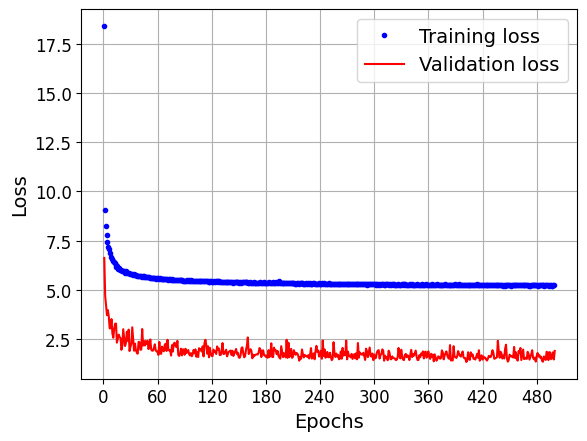

In [ ]:
#The curves show that there is underfitting

plot_learning_curves(history_model_LSTM_85_units_22_dropout_500_epochs.history["loss"], history_model_LSTM_85_units_22_dropout_500_epochs.history["val_loss"])
plt.show()

## Section 4: Model evaluation where we tested the model on different performance measures on the test set.

Mean Absolute Error (MAE): This metric measures the average absolute difference between the predicted and actual exposure.

Mean Squared Error (MSE): This metric calculates the average of the squared differences between the predicted and actual values.

Root Mean Squared Error (RMSE): I a common metric for evaluating regression models. The RMSE is  the square root of the MSE nd provides a measure of the average magnitude of the prediction errors.

R-squared (R^2 Score: This metric indicates the proportion of the variance in the dependent variable (actual values that can be explained by the independent variable (predictions). For R^2, a value closer to 1 indicates a better fit of the model to the data.


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Inference of the model to the test set
Y_pred = model_LSTM_85_units_22_dropout_500_epochs.predict(X_test)

# Flatten the predictions and labels
Y_pred_flat = Y_pred.reshape(-1)
Y_test_flat = Y_test.reshape(-1)


# Calculate evaluation metrics
mae = mean_absolute_error(Y_test_flat, Y_pred_flat)
mse = mean_squared_error(Y_test_flat, Y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_flat, Y_pred_flat)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R^2 Score:', r2)

156/156 [==============================] - 1s 4ms/step
Mean Absolute Error (MAE): 0.011164688845477411
Mean Squared Error (MSE): 0.00556037021411348
Root Mean Squared Error (RMSE): 0.07456788996688507
R^2 Score: 0.9942696357615447


## Section 5: Model and scaler saving

In [ ]:
#Save the model and the Scaler for inference
from pickle import dump

# save the scaler object to a file
dump(scaler, open('/content/drive/MyDrive/scaler.pkl', 'wb'))

# save the model
model_LSTM_24_units_30_dropout_300_epochs.save('/content/drive/MyDrive/model_LSTM_85_units_22_dropout_500_epochs.h5')